In [0]:
!pip install tensorflow-gpu==2.0.0-rc1
!pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
import tensorflow as tf
print("Tensorflow Version:", tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_examples.models.pix2pix import pix2pix

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm import trange

from google.colab import drive
drive.mount('/content/drive')

Tensorflow Version: 2.0.0-rc1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def imgLoad(folder, shape, gray = True):
    im_dir = os.path.join("/content/drive/My Drive", folder)
    tmp = []

    file_list = os.listdir(im_dir)
    file_list = sorted(file_list, key = str.lower)

    for name in tqdm(file_list):
        path = os.path.join(im_dir, name)
        if gray:
            im = cv2.imread(path, 0)
            im = np.expand_dims(im, -1)
        else:
            im = cv2.imread(path)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, dsize = shape[:2])
        tmp.append(im)

    return np.array(tmp)

In [0]:
import random
from scipy import ndimage
from tqdm import tqdm
from tqdm import trange
from time import sleep

def data_augmentation(images, labels):
    aug_images = []
    aug_labels = []    
    
    cnt = 1
    for x, y in tqdm(zip(images, labels), total=images.shape[0]):

        aug_images.append(x)
        aug_labels.append(y)
        bg_value = np.median(x)
        
        for _ in range(8):
            angle = random.randint(-2, 2)
            rot_img = ndimage.rotate(x, angle, reshape=False, cval=bg_value)
            rot_label = ndimage.rotate(y, angle, reshape=False, cval=bg_value)
            
            shift = np.random.randint(-1, 1)
            shift_img = ndimage.shift(rot_img, shift, cval=bg_value)            
            shift_label = ndimage.shift(rot_label, shift, cval=bg_value)

            fliped_parameter = np.random.randint(2, size=1)
            fliped_parameter -= 1
            fliped_over_img = cv2.flip(x, fliped_parameter)
            fliped_over_label = cv2.flip(y, fliped_parameter)
            
            aug_images.append(shift_img)
            aug_images.append(rot_img)
            aug_images.append(fliped_over_img)

            aug_labels.append(shift_label)
            aug_labels.append(rot_label)
            aug_labels.append(fliped_over_label)

    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    return aug_images, aug_labels

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [0]:
def model(inputs_shape, output_channels):
    base_model = tf.keras.applications.MobileNetV2(input_shape=inputs_shape, include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 128x128
        'block_3_expand_relu',   # 64x64
        'block_6_expand_relu',   # 32x32
        'block_13_expand_relu',  # 16x16
        'block_16_project',      # 8x8
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
    # down_stack.trainable = False

    up_stack = [
    pix2pix.upsample(512, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(128, 3),  # 32x32 -> 64x64
    pix2pix.upsample(64, 3),   # 64x64 -> 128x128
    ]

    up_stack_plus = [
                     256,
                     128,
                     64,
                     32
    ]


    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #128x128 -> 256x256

    inputs = tf.keras.layers.Input(shape=inputs_shape)
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, kernelS, skip in zip(up_stack, up_stack_plus, skips):
        x = up(x)
        x = keras.layers.Conv2DTranspose(kernelS, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=keras.initializers.he_normal(), kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = keras.layers.Conv2DTranspose(kernelS, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=keras.initializers.he_normal(), kernel_regularizer=keras.regularizers.l2(0.01))(x)

        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
size = 256
test_model = model((size, size, 3), 3)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 128, 128, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 512)  1476608     model[1][4]                      
__________________________________________________________________________________________________
conv2d_transpose_5 (Conv2DTrans (None, 16, 16, 256)  131072      sequential[0][0]                 
____________________________________________________________________________________________

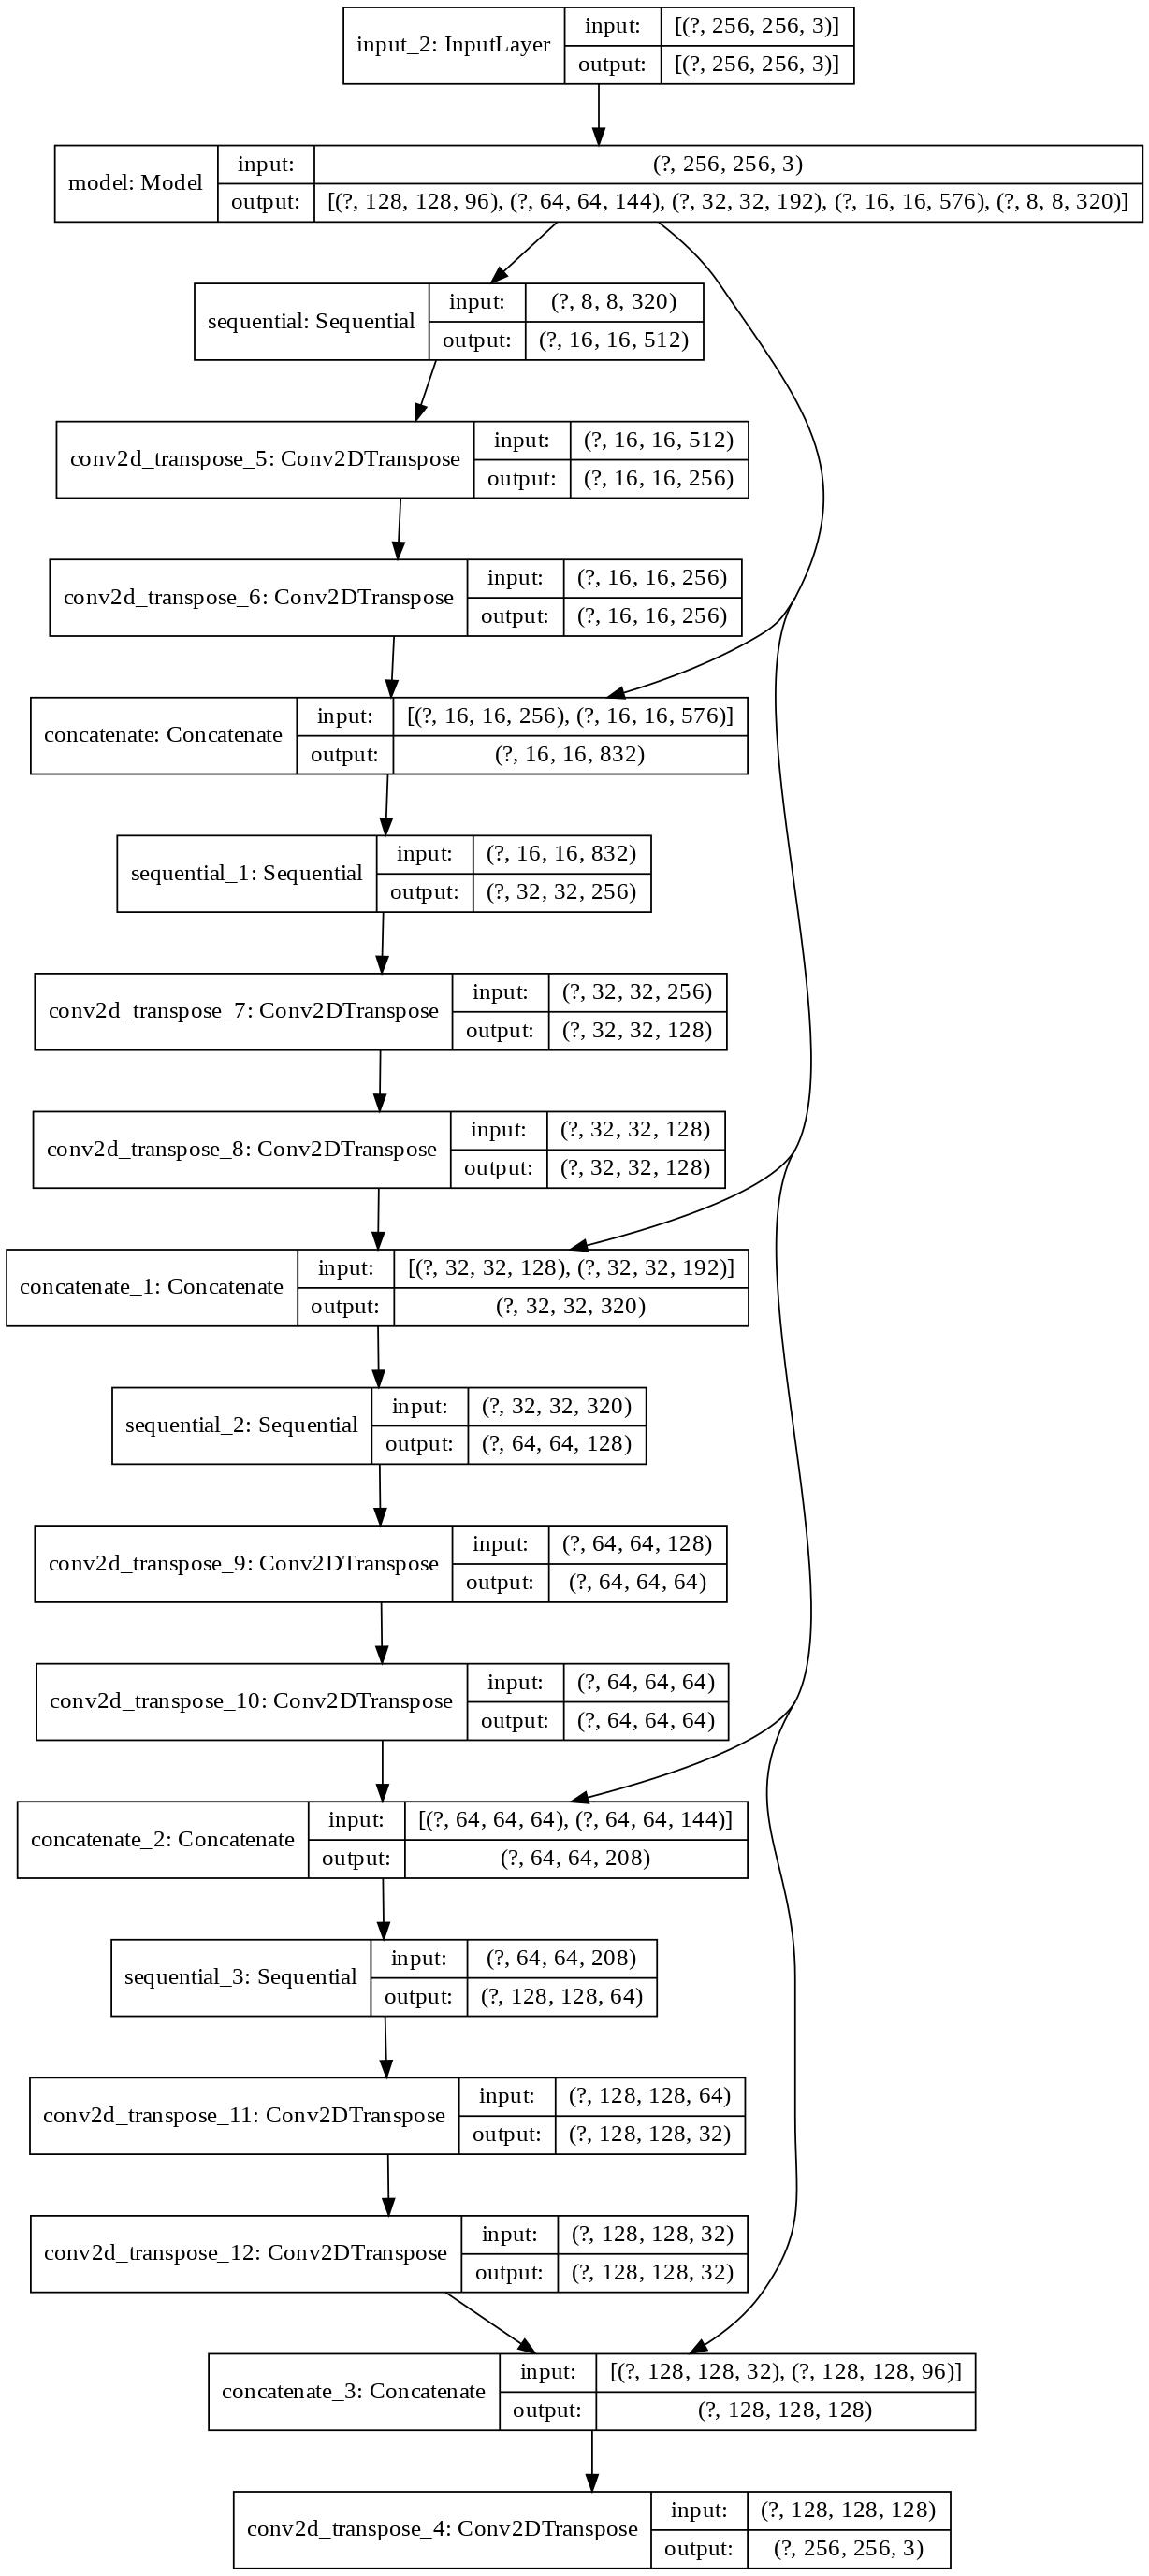

In [0]:
print(test_model.summary())
keras.utils.plot_model(test_model, 'Semantic Segmentation Model.png', show_shapes = True, expand_nested=False, dpi=128)

In [0]:
model_optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-4)

In [0]:
def model_loss(predict_mask, true_mask):
    # predict_mask = keras.layers.Reshape((size, size))(predict_mask)
    # pixel_wise = keras.layers.subtract([predict_mask, true_mask])
    # pixel_wise = keras.backend.abs(keras.layers.subtract([predict_mask, true_mask]))
    # return keras.losses.MeanAbsoluteError()(y_true=tf.zeros_like(pixel_wise), y_pred=pixel_wise)
    # return tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(pixel_wise), logits=pixel_wise)
    
    return keras.losses.MeanSquaredError()(y_true=true_mask, y_pred=predict_mask)
    # return keras.losses.SparseCategoricalCrossentropy()(y_true=true_mask, y_pred=predict_mask)
    # return keras.losses.MeanSquaredLogarithmicError()(y_true=true_mask, y_pred=predict_mask)
    # return keras.losses.MeanAbsoluteError()(y_true=true_mask, y_pred=predict_mask)

In [0]:
import datetime

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

train_loss = keras.metrics.Mean('train_loss', dtype=tf.float32)
train_acc = keras.metrics.Accuracy('train_accuracy')
# train_acc = keras.metrics.Accuracy("train_acc")
# test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)

In [0]:
@tf.function
def train_step(model, imgs, mask):
    with tf.GradientTape() as tape:
        predict = model(imgs, training=True)
        loss = model_loss(predict, mask)

    gradient = tape.gradient(loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    train_loss(loss)
    train_acc(mask, predict)
    return loss

In [0]:
from time import sleep

shape = (size, size, 3) 
train_images = imgLoad('workspace/Python/ML_Basic/Images/trainImg', shape, False)
train_truth = imgLoad('workspace/Python/ML_Basic/Images/GroundTruth', shape, True)

train_images, train_truth = data_augmentation(train_images, train_truth)

BUFFER_SIZE = 5000
BATCH_SIZE = 64

train_images = (train_images.astype('float32')/255.)
train_truth = (train_truth.astype('uint8')) 

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_truth)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

100%|██████████| 151/151 [03:23<00:00,  1.35s/it]


In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    # plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [0]:
%%time

import time
EPOCHS = 1000

model = model((size, size, 3), 1)
data_size = len(list(train_dataset))

for epoch in range(EPOCHS):
  start = time.time()
  print("Start Epoch_{}'s Training".format(epoch+1), end="\t\t")
  
  for images in tqdm(train_dataset, total=data_size):
    loss = train_step(model, images[0], images[1])

  with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)
  print ('Time taken for epoch {} is {} sec '.format(epoch + 1, time.time()-start))
  
  print("Chceking")
  case_n = np.random.randint(3700, size=1)
  # predict = tf.squeeze(model(tf.expand_dims(train_images[case_n[0]], 0), 0))
  # predict = model(tf.expand_dims(train_images[case_n[0]], 0))
  # predict = create_mask(predict)
  display([train_images[case_n[0]], train_truth[case_n[0]], tf.squeeze(model(tf.expand_dims(train_images[case_n[0]], 0)))])
  
  template = 'Epoch {}, Loss: {}, Acc: {}'
  print (template.format(epoch+1, train_loss.result(), train_acc.result()))
  #Reset metrics every epoch
  train_loss.reset_states()
  train_acc.reset_states()

Output hidden; open in https://colab.research.google.com to view.